In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import glob
import matplotlib.dates as mdates
from datetime import datetime
from tqdm import tqdm

# define functions

def reader(path, first_var, hours = 0):
    '''
    Reads SEMS/DASH data, adds datetime columns

    :param path: path to data file
    :param first_var: the name of the first column label
    :return: pandas DataFrame
    '''
    # Open the file and read the lines
    skip=1
    with open(path, "r") as file:
        # Iterate over the lines
        for line in file:
            # Strip leading and trailing whitespace
            line = line.strip()
            # Check if the line contains column names
            if line.startswith(first_var):
                # Split the line by whitespace and append to the columns list
                columns = line[1:].strip().split("\t")
                break  # Stop reading lines after finding column names
            skip+=1
    # Read the data into a DataFrame, skipping the first 6 rows of comments
    d = pd.read_csv(path, sep='\t', skiprows=skip, names=columns)

    # Creates datetime columns
    year = '20'+str(path[30:32])+'-1-1'
    if 'DOY.Frac' in d.keys():
        d['dt'] = pd.to_datetime(year) + pd.to_timedelta(d['DOY.Frac'], unit='D') - pd.Timedelta(days=1, hours = hours)
    if 'StartTimeSt' in d.keys():
        d['st_dt'] = pd.to_datetime(year) + pd.to_timedelta(d['StartTimeSt'], unit='D') - pd.Timedelta(days=1, hours = hours)
    if 'EndTimeSt' in d.keys():
        d['end_dt'] = pd.to_datetime(year) + pd.to_timedelta(d['EndTimeSt'], unit='D') - pd.Timedelta(days=1, hours = hours)
    return d

def glob_reader(file_key, first_var, subfolder = './data/', hours = 0):
    '''
    Reads groups of data files and merges them into one

    :param file_key: shared key in filenames
    :param first_var: the name of the first column label
    :param subfolder: name of the subfolder containing the data
    :return: pandas DataFrame
    '''
    paths = sorted(glob.glob(subfolder+'*'+file_key+'*'))
    d = []
    for i in range(0, len(paths)):
        d.append(reader(paths[i], first_var, hours=hours))
    d = pd.concat(d).reset_index()
    return d

def icr_read(path):
    # path to data -> pandas DataFrame with time columns converted to date time
    with open(path) as f:
        # find the value in the file which tells you how many lines to skip to get to the table
        first_line = f.readline()
        header_line = int(first_line[0:-2].split(",")[0])-1
    data = pd.read_csv(path, sep=',', skiprows=header_line)

    # finds the location in the path containing the date
    acc = 0
    boo = False
    for letter in path:
        if letter == '2':
            boo = True
        elif boo and letter == '0':
            acc -= 1
            break
        acc += 1
        
    # creates datetime object with the date the data was collected
    dt = datetime(int(path[acc:acc+4]), int(path[acc+4:acc+6]), int(path[acc+6:acc+8])) 
    
    for column in data.keys():
        if 'UTC' in column:
            # converts seconds after midnight columns to datetime
            data[column] = dt + pd.to_timedelta(data[column], unit='seconds')
    data.columns = data.columns.str.replace(' ', '')
    return data.replace(-9999, np.NaN) # Converts -9999 values to NaN

def glob_icr_reader(file_key, subfolder = './data/'):
    '''
    Reads groups of data files and merges them into one

    :param file_key: shared key in filenames
    :param first_var: the name of the first column label
    :param subfolder: name of the subfolder containing the data
    :return: pandas DataFrame
    '''
    paths = sorted(glob.glob(subfolder+'*'+file_key+'*'))
    d = []
    for i in range(0, len(paths)):
        d.append(icr_read(paths[i]))
    d = pd.concat(d).reset_index()
    return d

In [2]:
all_d = glob_reader('*DASH_BIN_CNT*', '#StartTimeSt', subfolder='../data/old_dash/', hours = -7)

In [3]:
DC3_sum = glob_icr_reader('*DC3-dc8Hskping_DC8*', subfolder='../data/old_dash/')

In [4]:
DC3_dash = glob_icr_reader('*DC3-DASH*', subfolder='../data/old_dash/')

In [5]:
sum_mean = pd.DataFrame(columns=DC3_sum.keys())
sd_mean = pd.DataFrame(columns=all_d.keys())
for i in tqdm(range(0,len(DC3_dash))):
    row = DC3_dash.iloc[i]
    t_start = row['UTC_Start_time']
    t_stop = row['UTC_Stop_time']
    sd_mean.loc[len(sd_mean)] = all_d[(all_d['st_dt'] > t_start) & (all_d['end_dt'] < t_stop)].sum(numeric_only=True)
    sum_mean.loc[len(sum_mean)] = DC3_sum[(DC3_sum['Start_UTC'] > t_start) & (DC3_sum['Start_UTC'] < t_stop)].median(numeric_only=True)
d = pd.merge(DC3_dash, sum_mean, left_index=True, right_index=True)
d = pd.merge(d, sd_mean, left_index=True, right_index=True)

100%|██████████| 8028/8028 [00:49<00:00, 162.02it/s]


In [6]:
columns_with_do_bin = d.filter(like='DO_B').columns
d['DO_sum'] = d[columns_with_do_bin].sum(axis=1, skipna=True)
d['DO_max'] = d[columns_with_do_bin].max(axis=1, skipna=True)

columns_with_ho_bin = d.filter(like='HO_B').columns
d['HO_sum'] = d[columns_with_ho_bin].sum(axis=1, skipna=True)
d['HO_max'] = d[columns_with_ho_bin].max(axis=1, skipna=True)

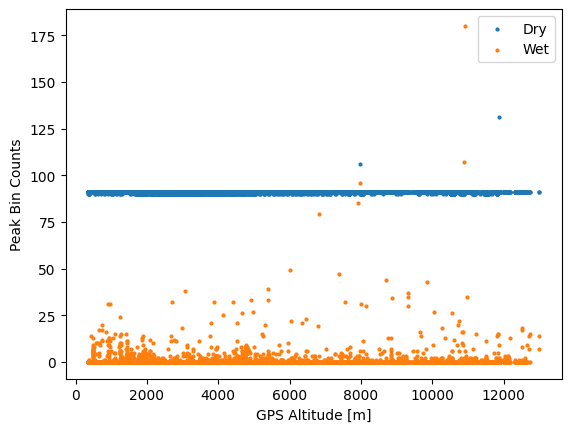

In [7]:
plt.scatter(d['GPS_Altitude'], d['DO_max'], label='Dry', s=4)
plt.scatter(d['GPS_Altitude'], d['HO_max'], label='Wet', s=4)
#plt.ylim([0,50])
plt.xlabel('GPS Altitude [m]')
plt.ylabel('Peak Bin Counts')
plt.legend()

In [8]:
t_start

Timestamp('2012-06-23 03:11:58')

In [9]:
t_stop

Timestamp('2012-06-23 03:12:19')

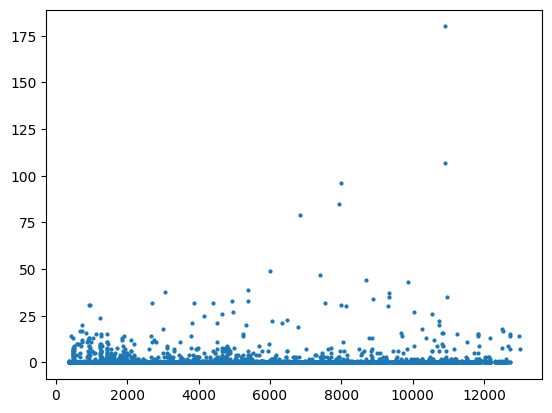

In [10]:
plt.scatter(d['GPS_Altitude'], d['HO_max'], label='Dry', s=4)
#plt.ylim([90,95])

In [11]:
all_d = glob_reader('*DASH_BIN_CNT*', '#StartTimeSt', subfolder='../data/old_dash/', hours = -7)
DC3_sum = glob_icr_reader('*SEAC4RS-4STAR-AOD-CWV_DC8_20130806_R2.ict*', subfolder='../data/old_dash/')
DC3_dash = glob_icr_reader('*SEAC4RS-DASH-SP_DC8*', subfolder='../data/old_dash/')
sum_mean = pd.DataFrame(columns=DC3_sum.keys())
sd_mean = pd.DataFrame(columns=all_d.keys())
for i in tqdm(range(0,len(DC3_dash))):
    row = DC3_dash.iloc[i]
    t_start = row['UTC_Start_time']
    t_stop = row['UTC_Stop_time']
    sd_mean.loc[len(sd_mean)] = all_d[(all_d['st_dt'] > t_start) & (all_d['end_dt'] < t_stop)].sum(numeric_only=True)
    sum_mean.loc[len(sum_mean)] = DC3_sum[(DC3_sum['Start_UTC'] > t_start) & (DC3_sum['Start_UTC'] < t_stop)].median(numeric_only=True)
d = pd.merge(DC3_dash, sum_mean, left_index=True, right_index=True)
d = pd.merge(d, sd_mean, left_index=True, right_index=True)

100%|██████████| 19764/19764 [01:42<00:00, 193.12it/s]


In [14]:
list(d.keys())

['index_x',
 'UTC_Start_time',
 'UTC_Stop_time',
 'UTC_mid_time',
 'Dp',
 'RH',
 'GF',
 'index_y',
 'Start_UTC',
 'Latitude',
 'Longitude',
 'GPS_alt',
 'qual_flag',
 'amass_aer',
 'T4temp',
 'CWV',
 'std_CWV',
 'AOD0380',
 'AOD0452',
 'AOD0501',
 'AOD0520',
 'AOD0532',
 'AOD0550',
 'AOD0606',
 'AOD0620',
 'AOD0675',
 'AOD0781',
 'AOD0865',
 'AOD1020',
 'AOD1040',
 'AOD1064',
 'AOD1236',
 'AOD1559',
 'AOD1627',
 'UNCAOD0380',
 'UNCAOD0452',
 'UNCAOD0501',
 'UNCAOD0520',
 'UNCAOD0532',
 'UNCAOD0550',
 'UNCAOD0606',
 'UNCAOD0620',
 'UNCAOD0675',
 'UNCAOD0781',
 'UNCAOD0865',
 'UNCAOD1020',
 'UNCAOD1040',
 'UNCAOD1064',
 'UNCAOD1236',
 'UNCAOD1559',
 'UNCAOD1627',
 'index',
 'StartTimeSt',
 'EndTimeSt',
 'StartYr',
 'EndYr',
 'StartSecs',
 'EndSecs',
 'Samp_Num',
 'NumBins',
 'DO_Bin0',
 'DO_Bin1',
 'DO_Bin2',
 'DO_Bin3',
 'DO_Bin4',
 'DO_Bin5',
 'DO_Bin6',
 'DO_Bin7',
 'DO_Bin8',
 'DO_Bin9',
 'DO_Bin10',
 'DO_Bin11',
 'DO_Bin12',
 'DO_Bin13',
 'DO_Bin14',
 'DO_Bin15',
 'DO_Bin16',
 'DO_B

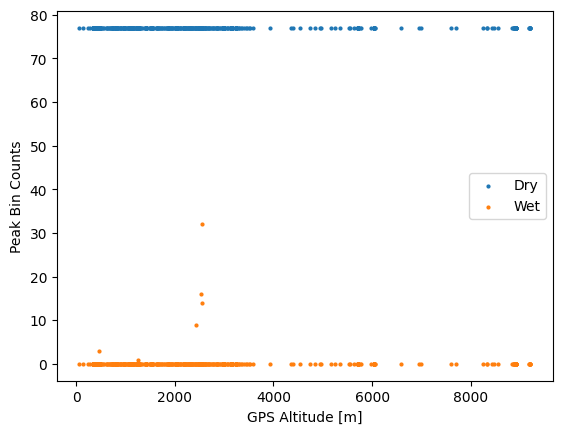

In [18]:
columns_with_do_bin = d.filter(like='DO_B').columns
d['DO_sum'] = d[columns_with_do_bin].sum(axis=1, skipna=True)
d['DO_max'] = d[columns_with_do_bin].max(axis=1, skipna=True)

columns_with_ho_bin = d.filter(like='HO_B').columns
d['HO_sum'] = d[columns_with_ho_bin].sum(axis=1, skipna=True)
d['HO_max'] = d[columns_with_ho_bin].max(axis=1, skipna=True)
plt.scatter(d['GPS_alt'], d['DO_max'], label='Dry', s=4)
plt.scatter(d['GPS_alt'], d['HO_max'], label='Wet', s=4)
#plt.ylim([0,50])
plt.xlabel('GPS Altitude [m]')
plt.ylabel('Peak Bin Counts')
plt.legend()